### Note:
This code for the fine-tuning process of XLNet for sentiment analysis is based on the following example, published on Medium: <br>
- link to article: https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85 <br>
- author: Shanay Ghag <br>
- published at: Jun 16, 2020 <br>
- link to GitHub: https://github.com/shanayghag/Sentiment-classification-using-XLNet

In [1]:
from datasets import load_dataset_builder, load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

import sentencepiece
from collections import defaultdict

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler, Dataset, DataLoader
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

In [2]:
# set up connection to drive: 
#from google.colab import drive
#drive.mount('/content/drive')

# define device: 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def prepare_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text) # remove @user 
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text) # remove links
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text) # remove smileys
    text = re.sub('#', '', text) # remove hash sign
    text = re.sub('\t', ' ',  text) # remove tab
    text = re.sub(r" +", ' ', text) # remove multiple whitespaces
    return text

# 1. Prepare Sentiment Dataset for Fine-Tuning

In [4]:
# load dataset from hugging face hub: sentiment140
sentiment_data = load_dataset('sentiment140')

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
sentiment_data_train = load_dataset('sentiment140', split='train')
sentiment_data_test = load_dataset('sentiment140', split='test')

In [6]:
text = sentiment_data_train['text']
sentiment = sentiment_data_train['sentiment']
df_sentiment = pd.DataFrame({'text': text, 'sentiment': sentiment})


In [7]:
# plot length of each tweet in order to define max_length
# define tokenizer:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

token_lens = []

for txt in df_sentiment['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


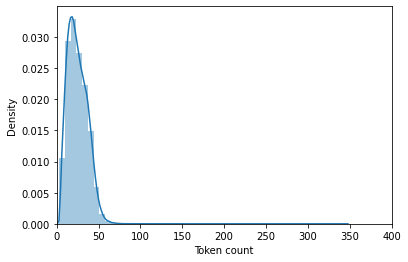

In [8]:
sns_plot = sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count')

fig = sns_plot.get_figure()
fig.savefig('token_length_sentiment.png');

In [9]:
df_sentiment = shuffle(df_sentiment) # 0 = negative; 2 = neutral; 4 = positive
df_sentiment = df_sentiment[:24000] # take only a subset

In [10]:
df_sentiment['text'] = df_sentiment['text'].apply(prepare_text)

In [11]:
# change label: 0: negative; 1: positive
df_sentiment.loc[(df_sentiment.sentiment == 4),'sentiment']=1
df_sentiment

,text,sentiment
1253544,You should check out if you dare hashtagmafia,1
1251459,TELL MARISA I SAID HI AND TO BRING BACK SOME ...,1
1561271,I really like the weather these days...It's be...,1
1019350,U are now following the most underestimated du...,1
477287,Bye bye. I have school tomorrow.,0
...,...,...
736146,wanna go for a walk with my son but looks like...,0
807949,Womens prayer this am...Tomorrow is mens,1
308634,trying to compile C code and running into depe...,0
1198485,I haven't read quot Mindless Eating quot so I...,1


negative tweets: 12017
positive tweets: 11983


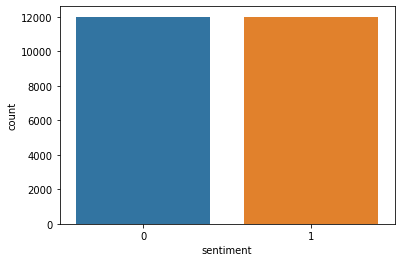

In [12]:
sns_plot = sns.countplot(x=df_sentiment.sentiment) # to see class distribution
print(f'negative tweets: {len(df_sentiment[df_sentiment["sentiment"] == 0])}')
print(f'positive tweets: {len(df_sentiment[df_sentiment["sentiment"] == 1])}')

fig = sns_plot.get_figure()
fig.savefig('class_dist_sentiment.png');

In [13]:
class_names = ['negative', 'positive']

In [14]:
df_sentiment.to_csv('test.csv')

# 2. Load XLNet, Prepare Inputs and Define Hyperparameter

In [15]:
# define max length: 
MAX_LEN = 400

In [16]:
# custom dataset class
class SentimentDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
    
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              truncation=True,
                                              return_token_type_ids=False,
                                              pad_to_max_length=False,
                                              return_attention_mask=True,
                                              return_tensors='pt',)
        
        input_ids = pad_sequences(encoding['input_ids'], 
                                  maxlen=MAX_LEN, 
                                  dtype=torch.Tensor ,
                                  truncating="post",
                                  padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], 
                                       maxlen=MAX_LEN, 
                                       dtype=torch.Tensor ,
                                       truncating="post",
                                       padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       
        
        return {'review_text': review,
                'input_ids': input_ids,
                'attention_mask': attention_mask.flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [17]:
# create training, validation and test set: 
df_train, df_test = train_test_split(df_sentiment, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [18]:
# check shape
df_train.shape, df_val.shape, df_test.shape

((12000, 2), (6000, 2), (6000, 2))

In [19]:
# define custom dataloader:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(reviews=df.text.to_numpy(),
                          targets=df.sentiment.to_numpy(),
                          tokenizer=tokenizer,
                          max_len=max_len)
    
    return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=2)                    

In [20]:
# define batch size: 
BATCH_SIZE = 8

# create data loader for training, validation and test set: 
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
# load pre-trained XLNet model
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [22]:
# defining hyperparameters:
EPOCHS = 2

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [23]:
# sanity check: 
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)

print(input_ids.reshape(8,400).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 400])
torch.Size([8, 400])


In [25]:
outputs = model(input_ids.reshape(8,400), 
                token_type_ids=None, 
                attention_mask=attention_mask, 
                labels=targets)

In [26]:
type(outputs[0]) # shoul be torch.Tensor

torch.Tensor

In [27]:
# define training step function:
from sklearn import metrics

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].reshape(8,400).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]
        
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1
    
    return acc / counter, np.mean(losses)

In [28]:
# define evaluation function:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(8,400).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]
            
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)
            
            acc += accuracy
            losses.append(loss.item())
            counter += 1
        
    return acc / counter, np.mean(losses)

# 3. Fine-Tune the Model

In [29]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # call train function
    train_acc, train_loss = train_epoch(model,
                                      train_data_loader,
                                      optimizer,
                                      device, 
                                      scheduler, 
                                      len(df_train))
    
    print(f'Train loss {train_loss} Train accuracy {train_acc}')
    
    # call evaluation function
    val_acc, val_loss = eval_model(model,
                                 val_data_loader, 
                                 device, 
                                 len(df_val))
    
    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'xlnet_model_sentiment.bin') # note: this scrip was implemented using Kaggle's GPU. The model was saved into the Kaggle repo and downloaded manually

        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.5137223646665613 Train accuracy 0.755
Val loss 0.46326861948519943 Val accuracy 0.803

Epoch 2/2
----------
Train loss 0.3723538823484754 Train accuracy 0.8664166666666666
Val loss 0.6169888174707691 Val accuracy 0.8126666666666666

CPU times: user 35min 2s, sys: 5.46 s, total: 35min 7s
Wall time: 35min 20s


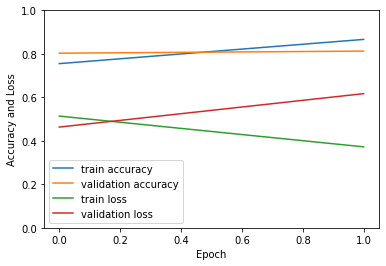

In [30]:
fig = plt.figure()
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
#plt.title('Training History')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
fig.savefig('training_sentiment.png');

# 4. Evaluation of Fine-Tuned Model

In [31]:
# read model saved in previous step:
# when connected to GPU:
model.load_state_dict(torch.load('xlnet_model_sentiment.bin'))

# when not connected to GPU (hence no cuda):
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models/xlnet_model_sentiment.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
model = model.to(device)

In [33]:
# call evaluation function and apply to test set
test_acc, test_loss = eval_model(model,
                                 test_data_loader,
                                 device,
                                 len(df_test))

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.8168333333333333
Test Loss : 0.5929788946062327


In [34]:
# define function to get prediction of data
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(8,400).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids,
                      token_type_ids=None,
                      attention_mask=attention_mask,#
                      labels=targets)
            
            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [35]:
# call prediction function to get actual predictions of test set 
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))
report = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv('report_sentiment.csv')

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      3023
    positive       0.81      0.82      0.82      2977

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


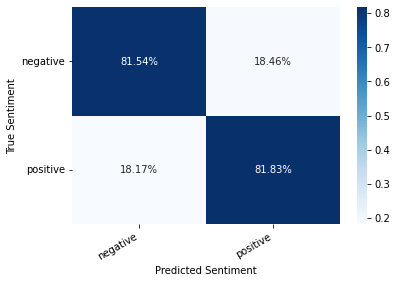

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.savefig('confusion_sentiment');
    

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv('cm_sentiment.csv')

show_confusion_matrix(df_cm)